# load file

In [1]:
base_dir = "/home/datamind/can/BASIL/"

In [2]:
import sys
import os
import math
os.chdir(base_dir)
sys.path.append(base_dir)

# BEST2010

In [3]:
import pickle
import pandas as pd
from basil.preprocessing.prep_best_corpus import Best2010NECTEC
from basil.preprocessing.prep_pytorch import PytorchPrepWordLevel
from sklearn.metrics import f1_score
import numpy as np

best2010  = Best2010NECTEC()
prep_torch = PytorchPrepWordLevel(best2010.train_data, best2010.val_data, best2010.test_data)
y_true_pos = [prep_torch.pos_to_index[word] for text in prep_torch.pos_test for word in text]
y_true_ner = [prep_torch.ner_to_index[word] for text in prep_torch.ner_test for word in text]
pos_labels = list(range(len(prep_torch.index_to_pos)))
pos_labels.remove(prep_torch.pos_to_index['space'])
ner_labels = list(range(len(prep_torch.index_to_ner)))
ner_labels.remove(prep_torch.ner_to_index['space'])
ner_labels.remove(prep_torch.ner_to_index['O'])


/home/datamind/can/BASIL/basil/preprocessing/prep_best_corpus.py:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(ymlfile)


Preprocessing BEST2010 corpus
Done!


In [4]:
# pos_pred = [item for sublist in pos_pred for item in sublist]
models_pos = ["y_pred_pos_setBiLSTM_Baseline","y_pred_pos_setBiLSTM_ELMO",
        "y_pred_pos_setBiLSTM_U","y_pred_pos_setBiLSTM_U_B","y_pred_pos_setBiLSTM_UBC",
         "y_pred_pos_setBiLSTM_BA","y_pred_pos_setBiLSTM_BA_clp","y_pred_pos_setBiLSTM_U_BCA_clp",
        "y_pred_pos_setBiLSTM_BCAD_clp"]
models_ner = ["y_pred_ner_setBiLSTM_Baseline","y_pred_ner_setBiLSTM_ELMO",
        "y_pred_ner_setBiLSTM_U","y_pred_ner_setBiLSTM_U_B","y_pred_ner_setBiLSTM_UBC",
         "y_pred_ner_setBiLSTM_BA","y_pred_ner_setBiLSTM_BA_clp","y_pred_ner_setBiLSTM_U_BCA_clp",
        "y_pred_ner_setBiLSTM_BCAD_clp"]
# models = ["y_pred_pos_setBiLSTM_U"]
col_names =  ['model','task','stress level','Mi-F1 POS','Mi-F1 NER' ]
best_df  = pd.DataFrame(columns = col_names)
col_names2 =  ['model','stress level','Mi-F1 POS','Mi-F1 NER']
result_best_df  = pd.DataFrame(columns = col_names2)
for model_name_pos, model_name_ner in zip(models_pos,models_ner):
    pos_pred = []
    ner_pred = []
    pos_pred.append(pickle.load( open( base_dir+"results/"+model_name_pos+"-1.p", "rb" ) ))
    pos_pred.append(pickle.load( open( base_dir+"results/"+model_name_pos+"-2.p", "rb" ) ))
    pos_pred.append(pickle.load( open( base_dir+"results/"+model_name_pos+"-3.p", "rb" ) ))
    ner_pred.append(pickle.load( open( base_dir+"results/"+model_name_ner+"-1.p", "rb" ) ))
    ner_pred.append(pickle.load( open( base_dir+"results/"+model_name_ner+"-2.p", "rb" ) ))
    ner_pred.append(pickle.load( open( base_dir+"results/"+model_name_ner+"-3.p", "rb" ) ))
    model_name_pos=model_name_pos.replace("y_pred_pos_set",'')
    model_name_pos=model_name_pos.replace("_Baseline",' (baseline)')
    model_name_pos=model_name_pos.replace("_",'-')
    model_name_pos=model_name_pos.replace("UBC",'U-BC')
    model_name_pos=model_name_pos.replace("-BA",'-U-BA')
    model_name_pos=model_name_pos.replace("-BCAD",'-U-BCAD')
    model_name_pos=model_name_pos.replace("ELMO",'ELMo')    
    stress_lvl = [0,10,20,30,40,50,60,70,80,90,100]
    f1_pos = np.empty(3)
    f1_ner = np.empty(3)
    for count,stress in enumerate(stress_lvl):
        for seed in range(3):
            f1_pos[seed] = f1_score(y_true_pos,pos_pred[seed][count], average='micro', labels=pos_labels)*100
            f1_ner[seed] = f1_score(y_true_ner,ner_pred[seed][count], average='micro',labels=ner_labels)*100
    #         print('%s POS: %.3f +/- %.3f NER: %.3f +/- %.3f' %(stress ,f1_pos.mean() ,f1_pos.std(ddof=1) ,f1_ner.mean() ,f1_ner.std()*2))
            my_dic = {'model':model_name_pos,'seed':seed+1,'stress level':stress, 'Mi-F1 POS':f1_pos[seed],'Mi-F1 NER':f1_ner[seed]}
            best_df.loc[len(best_df)] = my_dic 
        print('%s POS: %.3f +/- %.3f NER: %.3f +/- %.3f' %(stress ,f1_pos.mean() ,f1_pos.std(ddof=1) ,f1_ner.mean() ,f1_ner.std(ddof=1)))
        f1_pos_mean = float("{0:.2f}".format(f1_pos.mean()))
        f1_ner_mean = float("{0:.2f}".format(f1_ner.mean()))
        s_pos = float("{0:.2f}".format(f1_pos.std(ddof=1)))
        s_ner = float("{0:.2f}".format(f1_ner.std(ddof=1)))
        print('%s POS: %.2f +/- %.2f ' %(stress ,f1_pos.mean() ,f1_pos.std(ddof=1) ))   
        my_dic = {'model':model_name_pos,'stress level':stress,
                  'Mi-F1 POS':str(f1_pos_mean)+" ("+str(s_pos)+")",
                  'Mi-F1 NER':str(f1_ner_mean)+" ("+str(s_ner)+")"
                 }
        result_best_df.loc[len(result_best_df)] = my_dic  


0 POS: 94.829 +/- 0.023 NER: 81.039 +/- 0.298
0 POS: 94.83 +/- 0.02 
10 POS: 90.234 +/- 0.043 NER: 75.778 +/- 0.437
10 POS: 90.23 +/- 0.04 
20 POS: 85.394 +/- 0.114 NER: 70.544 +/- 0.525
20 POS: 85.39 +/- 0.11 
30 POS: 80.479 +/- 0.124 NER: 63.964 +/- 1.234
30 POS: 80.48 +/- 0.12 
40 POS: 75.193 +/- 0.247 NER: 56.627 +/- 1.985
40 POS: 75.19 +/- 0.25 
50 POS: 69.578 +/- 0.616 NER: 48.523 +/- 3.340
50 POS: 69.58 +/- 0.62 
60 POS: 63.644 +/- 1.247 NER: 40.000 +/- 4.465
60 POS: 63.64 +/- 1.25 
70 POS: 57.337 +/- 2.119 NER: 31.904 +/- 5.077
70 POS: 57.34 +/- 2.12 
80 POS: 50.707 +/- 3.232 NER: 24.676 +/- 5.353
80 POS: 50.71 +/- 3.23 
90 POS: 43.635 +/- 4.296 NER: 18.688 +/- 4.900
90 POS: 43.64 +/- 4.30 
100 POS: 36.246 +/- 5.475 NER: 13.721 +/- 4.071
100 POS: 36.25 +/- 5.48 
0 POS: 94.267 +/- 0.037 NER: 79.925 +/- 0.216
0 POS: 94.27 +/- 0.04 
10 POS: 90.669 +/- 0.062 NER: 76.017 +/- 0.334
10 POS: 90.67 +/- 0.06 
20 POS: 86.982 +/- 0.097 NER: 72.117 +/- 0.260
20 POS: 86.98 +/- 0.10 
30 POS: 

In [5]:
result_best_df.pivot(index='model', columns='stress level', values='Mi-F1 POS').drop([10, 30,50,70,90], axis=1)


stress level,0,20,40,60,80,100
model,,,,,,
BiLSTM (baseline),94.83 (0.02),85.39 (0.11),75.19 (0.25),63.64 (1.25),50.71 (3.23),36.25 (5.48)
BiLSTM-ELMo,94.27 (0.04),86.98 (0.1),79.42 (0.17),71.78 (0.15),64.21 (0.22),56.27 (0.32)
BiLSTM-U,95.01 (0.03),87.55 (0.08),79.01 (0.1),68.97 (0.14),57.39 (0.21),43.08 (0.55)
BiLSTM-U-B,95.19 (0.03),87.4 (0.02),78.99 (0.17),69.72 (0.34),59.67 (0.65),48.0 (1.1)
BiLSTM-U-BA,95.15 (0.04),87.06 (0.06),78.45 (0.04),69.15 (0.11),59.06 (0.26),47.72 (0.79)
BiLSTM-U-BA-clp,95.24 (0.03),87.06 (0.03),78.18 (0.09),68.42 (0.22),57.64 (0.51),45.17 (1.1)
BiLSTM-U-BC,95.15 (0.09),87.02 (0.04),78.23 (0.1),68.74 (0.27),58.59 (0.39),47.18 (0.5)
BiLSTM-U-BCA-clp,95.2 (0.01),87.09 (0.1),78.28 (0.23),68.8 (0.41),58.67 (0.63),47.24 (0.84)
BiLSTM-U-BCAD-clp,95.18 (0.07),86.9 (0.04),77.96 (0.01),68.32 (0.02),57.94 (0.08),46.51 (0.62)


In [6]:
result_best_df.pivot(index='model', columns='stress level', values='Mi-F1 NER').drop([10, 30,50,70,90], axis=1).to_csv('bestner_result.csv')

### ORCHID

In [8]:
import pickle
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np
from basil.preprocessing.prep_orchid_corpus import ORCHID
from basil.preprocessing.prep_pytorch_ORCHID import PytorchPrepWordLevel

orchid  = ORCHID()
prep_torch = PytorchPrepWordLevel(orchid.train_data, orchid.val_data, orchid.test_data)
y_true_pos = [prep_torch.pos_to_index[word] for text in prep_torch.pos_test for word in text]

pos_labels = list(range(len(prep_torch.index_to_pos)))



stress_orchid = pickle.load( open( base_dir+"stress_orchid.p", "rb" ) )
error10 = [item for sublist in stress_orchid.error10   for item in sublist] 
error20 = [item for sublist in stress_orchid.error20   for item in sublist] 
error30 = [item for sublist in stress_orchid.error30   for item in sublist] 
error40 = [item for sublist in stress_orchid.error40   for item in sublist] 
error50 = [item for sublist in stress_orchid.error50   for item in sublist] 
error60 = [item for sublist in stress_orchid.error60   for item in sublist] 
error70 = [item for sublist in stress_orchid.error70   for item in sublist] 
error80 = [item for sublist in stress_orchid.error80   for item in sublist] 
error90 = [item for sublist in stress_orchid.error90   for item in sublist] 
error100 = [item for sublist in stress_orchid.error100   for item in sublist] 


Preprocessing ORCHID corpus
Done!


In [9]:
# pos_pred = [item for sublist in pos_pred for item in sublist]
models = ["y_pred_pos_setBiLSTM_baseline_ORCHID","y_pred_pos_setBiLSTM_ELMO_ORCHID",
        "y_pred_pos_setBiLSTM_U_ORCHID","y_pred_pos_setBiLSTM_UB_ORCHID","y_pred_pos_setBiLSTM_UBC_ORCHID",
         "y_pred_pos_setBiLSTM_UBA_ORCHID","y_pred_pos_setBiLSTM_UBA_clp_ORCHID","y_pred_pos_setBiLSTM_UBCA_clp_ORCHID",
        "y_pred_pos_setBiLSTM_U_BCAD_clp_ORCHID","y_pred_pos_setBiLSTM_baseline_cprop_ORCHID"]
# models = ["y_pred_pos_setBiLSTM_U"]
# models = ["y_pred_pos_setBiLSTM_U"]
col_names =  ['model', 'seed','stress level','Mi-F1']
orchid_df  = pd.DataFrame(columns = col_names)
col_names2 =  ['model','stress level','Mi-F1']
result_orchid_df  = pd.DataFrame(columns = col_names2)
for model_name_pos in models:
    pos_pred = []
    pos_pred.append(pickle.load( open( base_dir+"results/"+model_name_pos+"-1.p", "rb" ) ))
    pos_pred.append(pickle.load( open( base_dir+"results/"+model_name_pos+"-2.p", "rb" ) ))
    pos_pred.append(pickle.load( open( base_dir+"results/"+model_name_pos+"-3.p", "rb" ) ))
    model_name_pos=model_name_pos.replace("y_pred_pos_set",'')
    model_name_pos=model_name_pos.replace("_ORCHID",'')
    model_name_pos=model_name_pos.replace("_baseline",' (baseline)')
    model_name_pos=model_name_pos.replace("_",'-')
    model_name_pos=model_name_pos.replace("-BA",'-U-BA')
    model_name_pos=model_name_pos.replace("UBC",'U-BC')
    model_name_pos=model_name_pos.replace("ELMO",'ELMo')
    stress_lvl = [0,10,20,30,40,50,60,70,80,90,100]
    f1_pos = np.empty(3)
    f1_pos_mean = []
    f1_pos_std = []
    print(model_name_pos)
    for count,stress in enumerate(stress_lvl):
        for seed in range(3):
        
            f1_pos[seed] = f1_score(y_true_pos,pos_pred[seed][count], average='micro', labels=pos_labels)*100
            my_dic = {'model':model_name_pos,'seed':seed+1,'stress level':stress, 'Mi-F1':f1_pos[seed]}
            orchid_df.loc[len(orchid_df)] = my_dic 
        f1_pos_mean = float("{0:.2f}".format(f1_pos.mean()))
        s = float("{0:.2f}".format(f1_pos.std(ddof=1)))
        print('%s POS: %.2f +/- %.2f ' %(stress ,f1_pos.mean() ,f1_pos.std(ddof=1) ))   
        my_dic = {'model':model_name_pos,'stress level':stress, 'Mi-F1':str(f1_pos_mean)+" ("+str(s)+")"}
        result_orchid_df.loc[len(result_orchid_df)] = my_dic 
    

BiLSTM (baseline)
0 POS: 94.01 +/- 0.18 
10 POS: 90.42 +/- 0.15 
20 POS: 86.88 +/- 0.19 
30 POS: 83.42 +/- 0.17 
40 POS: 79.48 +/- 0.07 
50 POS: 75.60 +/- 0.05 
60 POS: 71.82 +/- 0.22 
70 POS: 67.25 +/- 0.43 
80 POS: 62.79 +/- 0.77 
90 POS: 57.78 +/- 1.42 
100 POS: 52.40 +/- 2.10 
BiLSTM-ELMo
0 POS: 93.37 +/- 0.12 
10 POS: 91.18 +/- 0.07 
20 POS: 89.02 +/- 0.06 
30 POS: 87.07 +/- 0.07 
40 POS: 84.82 +/- 0.09 
50 POS: 82.58 +/- 0.11 
60 POS: 80.39 +/- 0.13 
70 POS: 78.00 +/- 0.03 
80 POS: 75.95 +/- 0.15 
90 POS: 73.46 +/- 0.15 
100 POS: 71.30 +/- 0.27 
BiLSTM-U
0 POS: 93.68 +/- 0.23 
10 POS: 90.75 +/- 0.27 
20 POS: 87.54 +/- 0.20 
30 POS: 84.24 +/- 0.40 
40 POS: 80.47 +/- 0.39 
50 POS: 76.56 +/- 0.39 
60 POS: 72.36 +/- 0.42 
70 POS: 67.56 +/- 0.53 
80 POS: 62.83 +/- 0.64 
90 POS: 57.62 +/- 0.55 
100 POS: 52.12 +/- 0.70 
BiLSTM-UB
0 POS: 94.89 +/- 0.10 
10 POS: 92.65 +/- 0.09 
20 POS: 90.35 +/- 0.14 
30 POS: 88.17 +/- 0.16 
40 POS: 85.60 +/- 0.15 
50 POS: 83.07 +/- 0.17 
60 POS: 80.66 +/

In [10]:
result_orchid_df

,model,stress level,Mi-F1
0,BiLSTM (baseline),0,94.01 (0.18)
1,BiLSTM (baseline),10,90.42 (0.15)
2,BiLSTM (baseline),20,86.88 (0.19)
3,BiLSTM (baseline),30,83.42 (0.17)
4,BiLSTM (baseline),40,79.48 (0.07)
5,BiLSTM (baseline),50,75.6 (0.05)
6,BiLSTM (baseline),60,71.82 (0.22)
7,BiLSTM (baseline),70,67.25 (0.43)
8,BiLSTM (baseline),80,62.79 (0.77)
9,BiLSTM (baseline),90,57.78 (1.42)


In [12]:
result_orchid_df.pivot(index='model', columns='stress level', values='Mi-F1').drop([10, 30,50,70,90], axis=1)

stress level,0,20,40,60,80,100
model,,,,,,
BiLSTM (baseline),94.01 (0.18),86.88 (0.19),79.48 (0.07),71.82 (0.22),62.79 (0.77),52.4 (2.1)
BiLSTM (baseline)-cprop,93.99 (0.19),86.85 (0.22),79.48 (0.12),71.7 (0.45),62.03 (1.85),50.07 (5.49)
BiLSTM-ELMo,93.37 (0.12),89.02 (0.06),84.82 (0.09),80.39 (0.13),75.95 (0.15),71.3 (0.27)
BiLSTM-U,93.68 (0.23),87.54 (0.2),80.47 (0.39),72.36 (0.42),62.83 (0.64),52.12 (0.7)
BiLSTM-U-BC,95.03 (0.12),89.94 (0.13),84.58 (0.24),79.0 (0.43),72.34 (0.82),65.78 (1.32)
BiLSTM-U-BCA-clp,94.92 (0.03),89.45 (0.18),83.71 (0.61),77.57 (0.76),70.75 (1.16),63.61 (1.68)
BiLSTM-U-BCAD-clp,94.98 (0.06),89.76 (0.34),84.52 (0.48),78.85 (0.74),72.42 (0.73),65.99 (0.86)
BiLSTM-UB,94.89 (0.1),90.35 (0.14),85.6 (0.15),80.66 (0.18),75.17 (0.3),69.61 (0.3)
BiLSTM-UBA,94.69 (0.1),88.9 (0.07),82.91 (0.3),76.7 (0.53),69.77 (0.82),62.89 (0.97)


In [13]:
result_orchid_df.pivot(index='model', columns='stress level', values='Mi-F1').drop([10, 30,50,70,90], axis=1).to_csv('orchid_result.csv')

In [12]:
orchid_df

,model,seed,stress level,Mi-F1
0,BiLSTM (baseline),1,0,91.641692
1,BiLSTM (baseline),2,0,92.263038
2,BiLSTM (baseline),3,0,91.902411
3,BiLSTM (baseline),1,10,86.969191
4,BiLSTM (baseline),2,10,87.332676
5,BiLSTM (baseline),3,10,87.095265
6,BiLSTM (baseline),1,20,82.344207
7,BiLSTM (baseline),2,20,82.831514
8,BiLSTM (baseline),3,20,82.201184
9,BiLSTM (baseline),1,30,78.129651


In [13]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


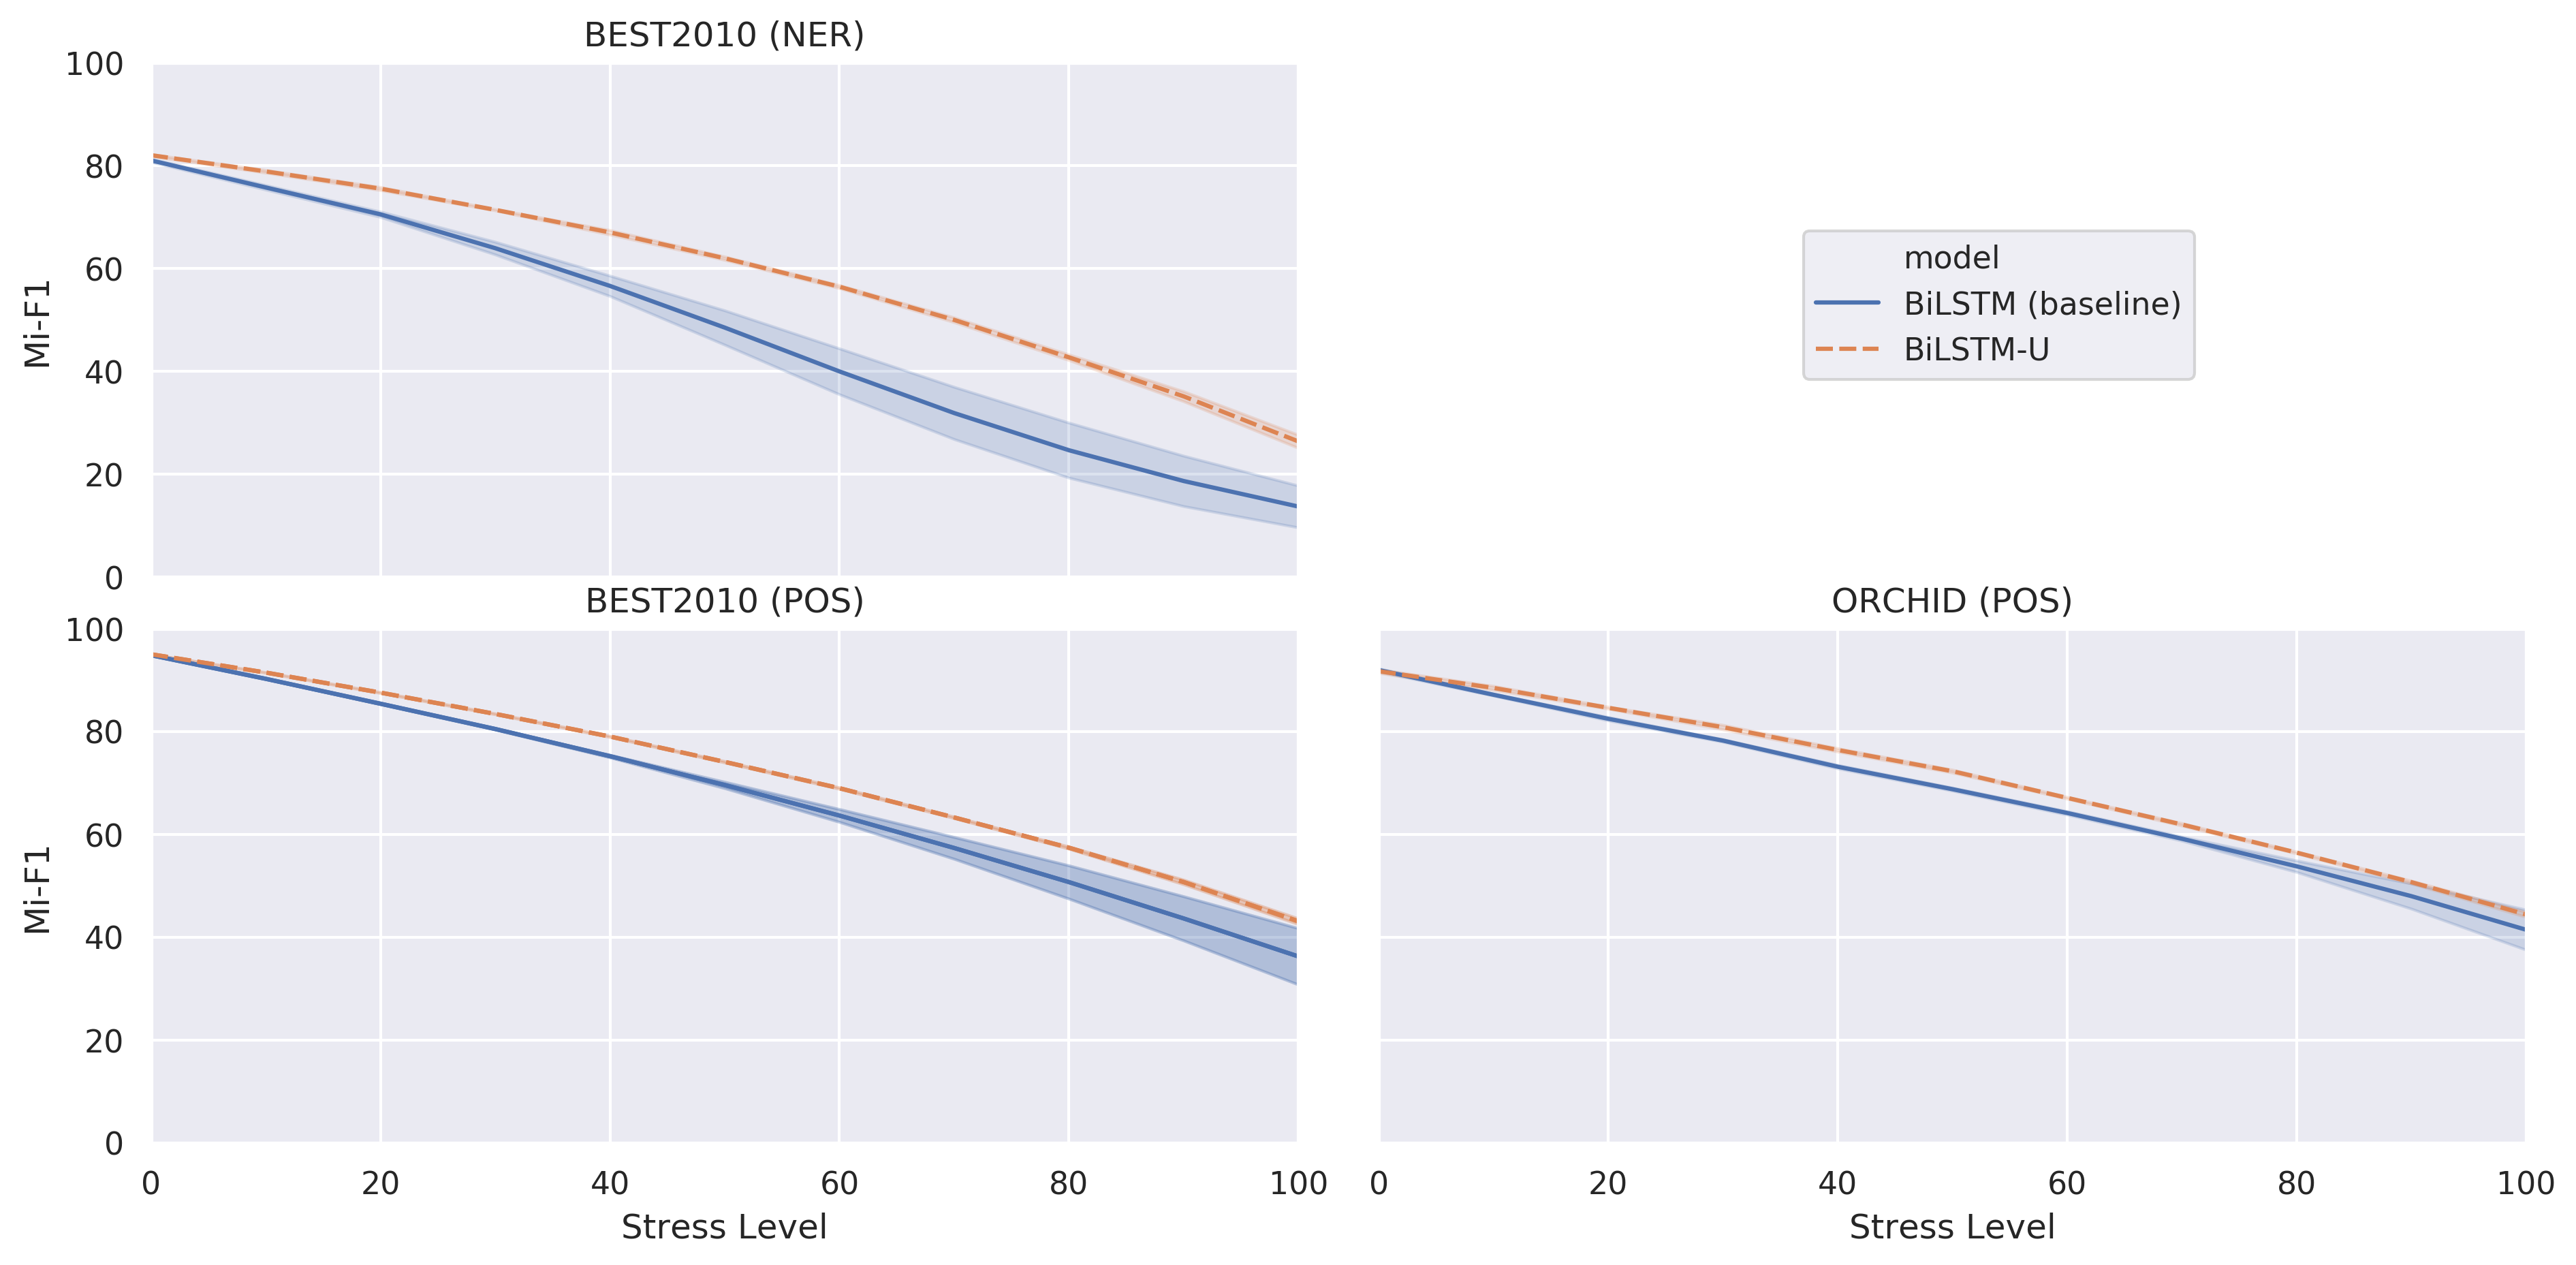

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,7),sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.07})
(ax1, ax2), (ax3, ax4) = axs
# fig.suptitle('Axes values are scaled individually by default')
ax2.set_facecolor('white')

mul_plt = sns.lineplot(x="stress level", y="Mi-F1 NER",ax=ax1,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM (baseline)") | (best_df.model=="BiLSTM-U") ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1",ax=ax4,legend=False, hue='model', style="model",ci="sd" ,data=orchid_df[(orchid_df.model=="BiLSTM (baseline)") | (orchid_df.model=="BiLSTM-U") ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM (baseline)") | (best_df.model=="BiLSTM-U") ])

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7, 0.7))
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM (baseline)") | (best_df.model=="BiLSTM-U") ])
mul_plt.legend_.remove()
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
sns.set_palette("colorblind")
mul_plt.set(ylim=(0, 100))
mul_plt.set(xlim=(0, 100))
ax1.set_title("BEST2010 (NER)")
ax3.set_title("BEST2010 (POS)")
ax4.set_title("ORCHID (POS)")
fig.set_dpi(300)
fig.savefig("UNK-MaskResults.pdf", bbox_inches='tight')

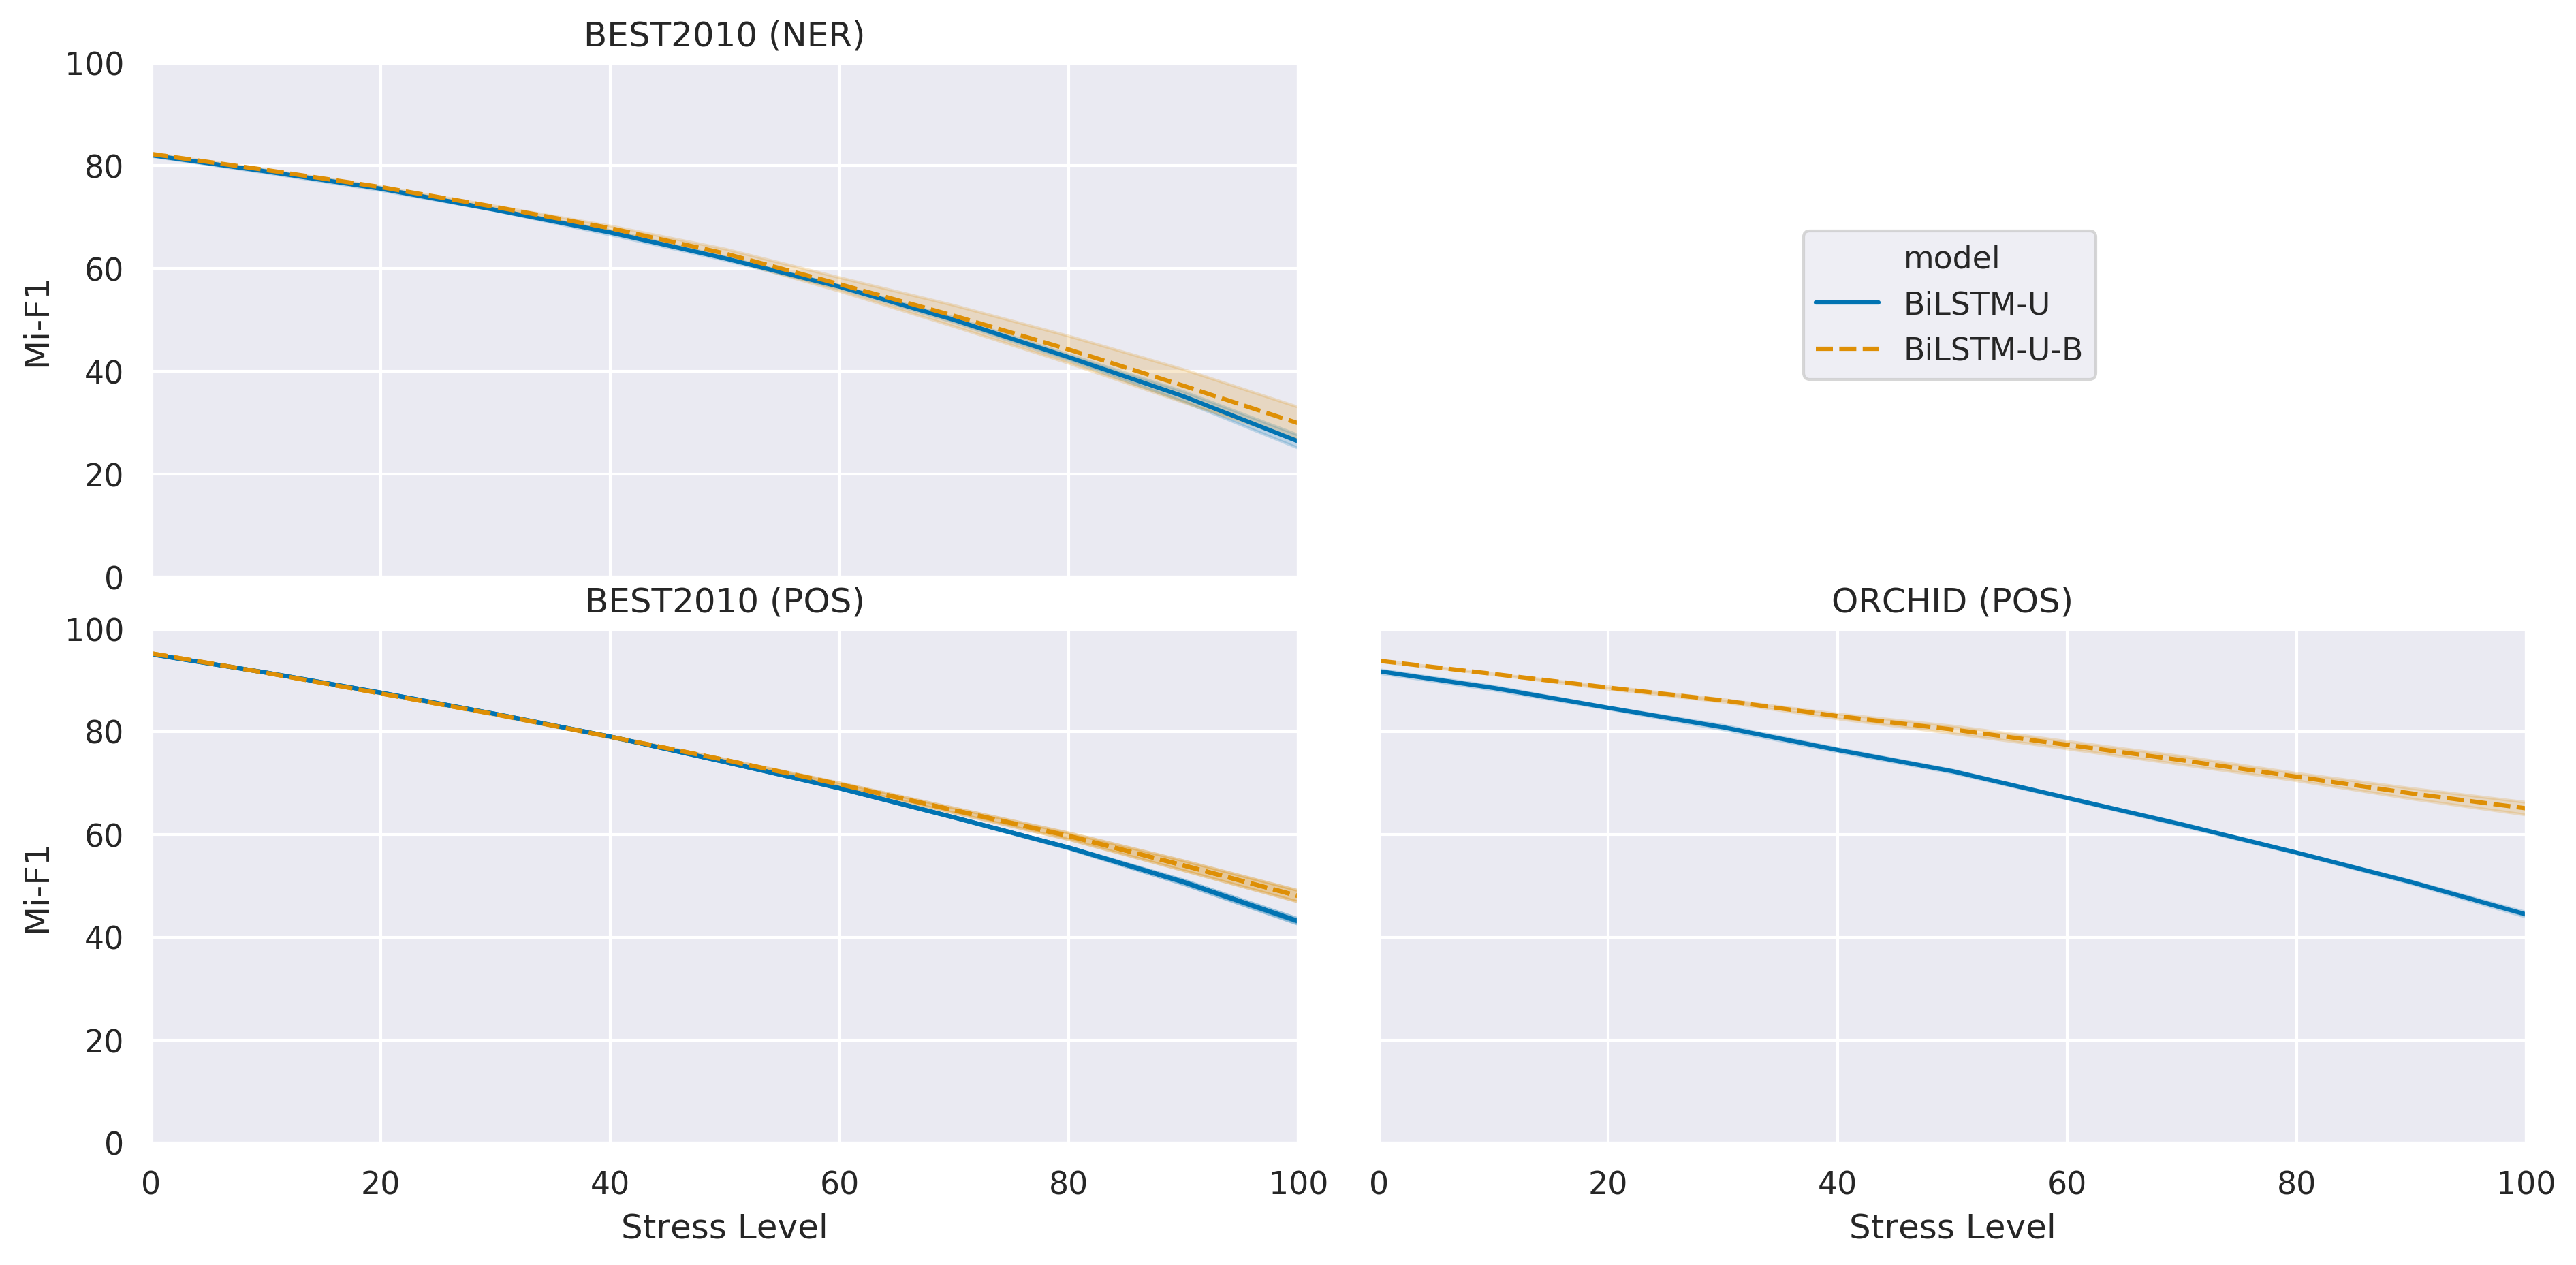

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,7),sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.07})
(ax1, ax2), (ax3, ax4) = axs
# fig.suptitle('Axes values are scaled individually by default')
ax2.set_facecolor('white')

mul_plt = sns.lineplot(x="stress level", y="Mi-F1 NER",ax=ax1,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U") | (best_df.model=="BiLSTM-U-B")  ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1",ax=ax4,legend=False, hue='model', style="model",ci="sd" ,data=orchid_df[(orchid_df.model=="BiLSTM-U") | (orchid_df.model=="BiLSTM-UB") ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U") | (best_df.model=="BiLSTM-U-B") ])

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7, 0.7))
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U") | (best_df.model=="BiLSTM-U-B") ])
mul_plt.legend_.remove()
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
sns.set_palette("colorblind")
mul_plt.set(ylim=(0, 100))
mul_plt.set(xlim=(0, 100))
ax1.set_title("BEST2010 (NER)")
ax3.set_title("BEST2010 (POS)")
ax4.set_title("ORCHID (POS)")
fig.set_dpi(300)
fig.savefig("Backoff-Results.pdf", bbox_inches='tight')

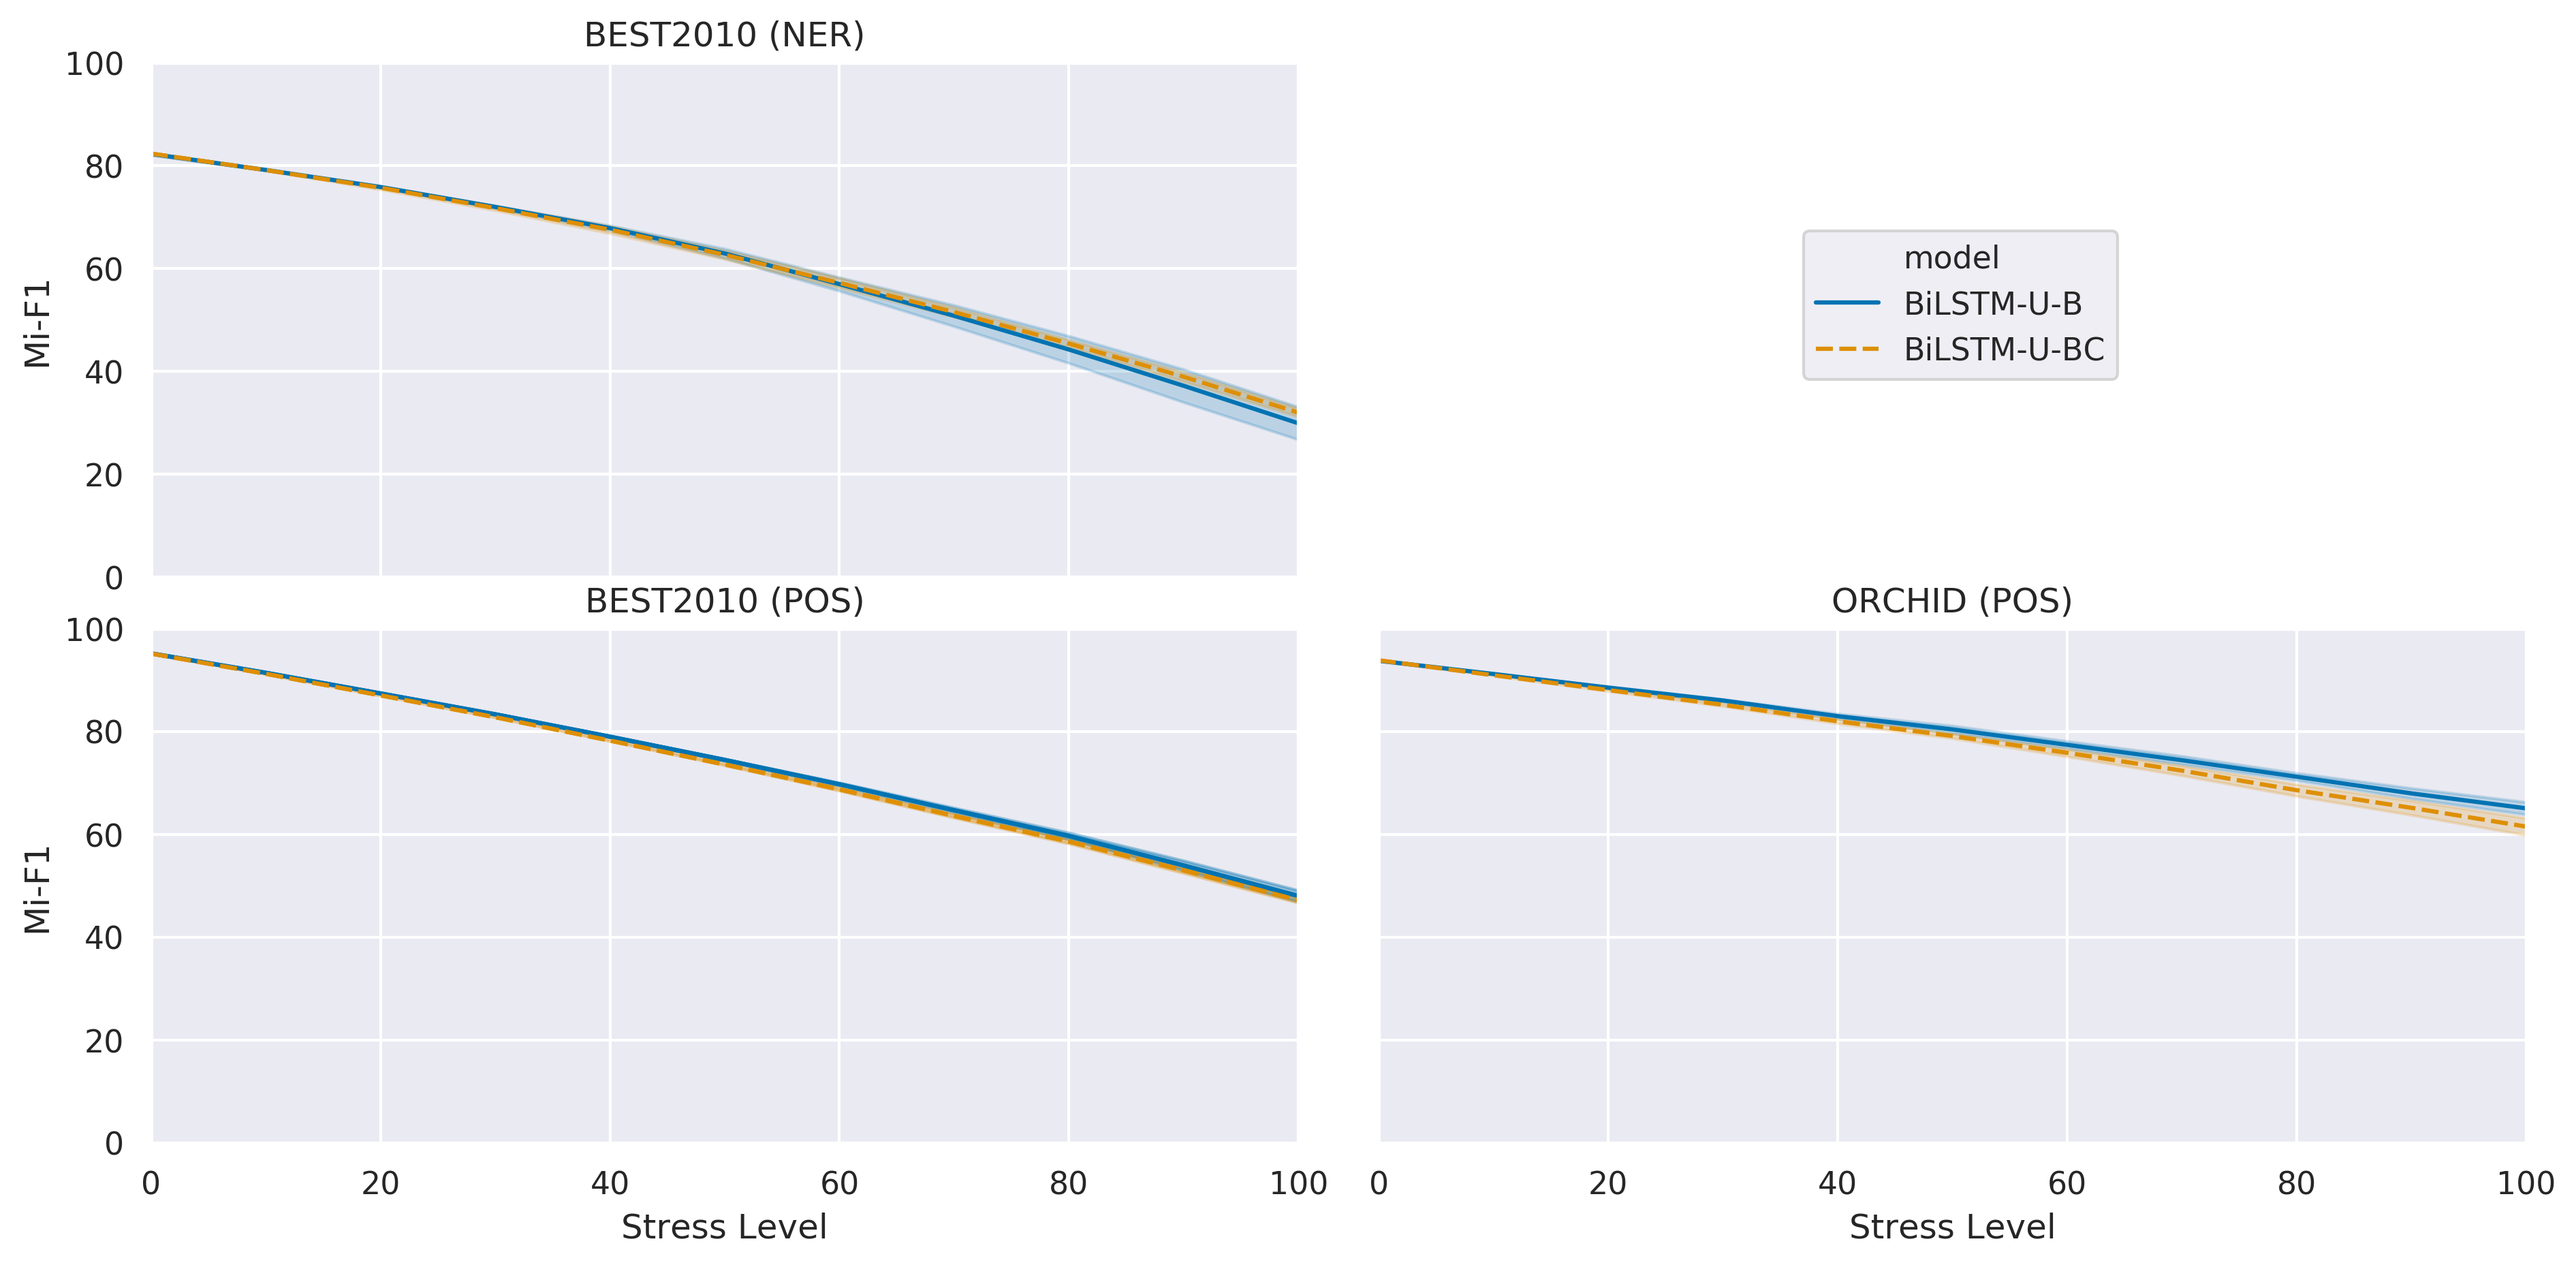

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,7),sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.07})
(ax1, ax2), (ax3, ax4) = axs
# fig.suptitle('Axes values are scaled individually by default')
ax2.set_facecolor('white')

mul_plt = sns.lineplot(x="stress level", y="Mi-F1 NER",ax=ax1,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U-B") | (best_df.model=="BiLSTM-U-BC")  ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1",ax=ax4,legend=False, hue='model', style="model",ci="sd" ,data=orchid_df[(orchid_df.model=="BiLSTM-UB") | (orchid_df.model=="BiLSTM-U-BC") ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U-B") | (best_df.model=="BiLSTM-U-BC") ])

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7, 0.7))
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U-B") | (best_df.model=="BiLSTM-U-BC") ])
mul_plt.legend_.remove()
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
sns.set_palette("colorblind")
mul_plt.set(ylim=(0, 100))
mul_plt.set(xlim=(0, 100))
ax1.set_title("BEST2010 (NER)")
ax3.set_title("BEST2010 (POS)")
ax4.set_title("ORCHID (POS)")
fig.set_dpi(300)
fig.savefig("Affixation-Results.pdf", bbox_inches='tight')

In [17]:
orchid_df["model"].unique()

array(['BiLSTM (baseline)', 'BiLSTM-ELMo', 'BiLSTM-U', 'BiLSTM-UB',
       'BiLSTM-U-BC', 'BiLSTM-UBA', 'BiLSTM-UBA-clp', 'BiLSTM-U-BCA-clp',
       'BiLSTM-U-BCAD-clp'], dtype=object)

In [18]:
best_df["model"].unique()

array(['BiLSTM (baseline)', 'BiLSTM-ELMo', 'BiLSTM-U', 'BiLSTM-U-B',
       'BiLSTM-U-BC', 'BiLSTM-U-BA', 'BiLSTM-U-BA-clp',
       'BiLSTM-U-BCA-clp', 'BiLSTM-U-BCAD-clp'], dtype=object)

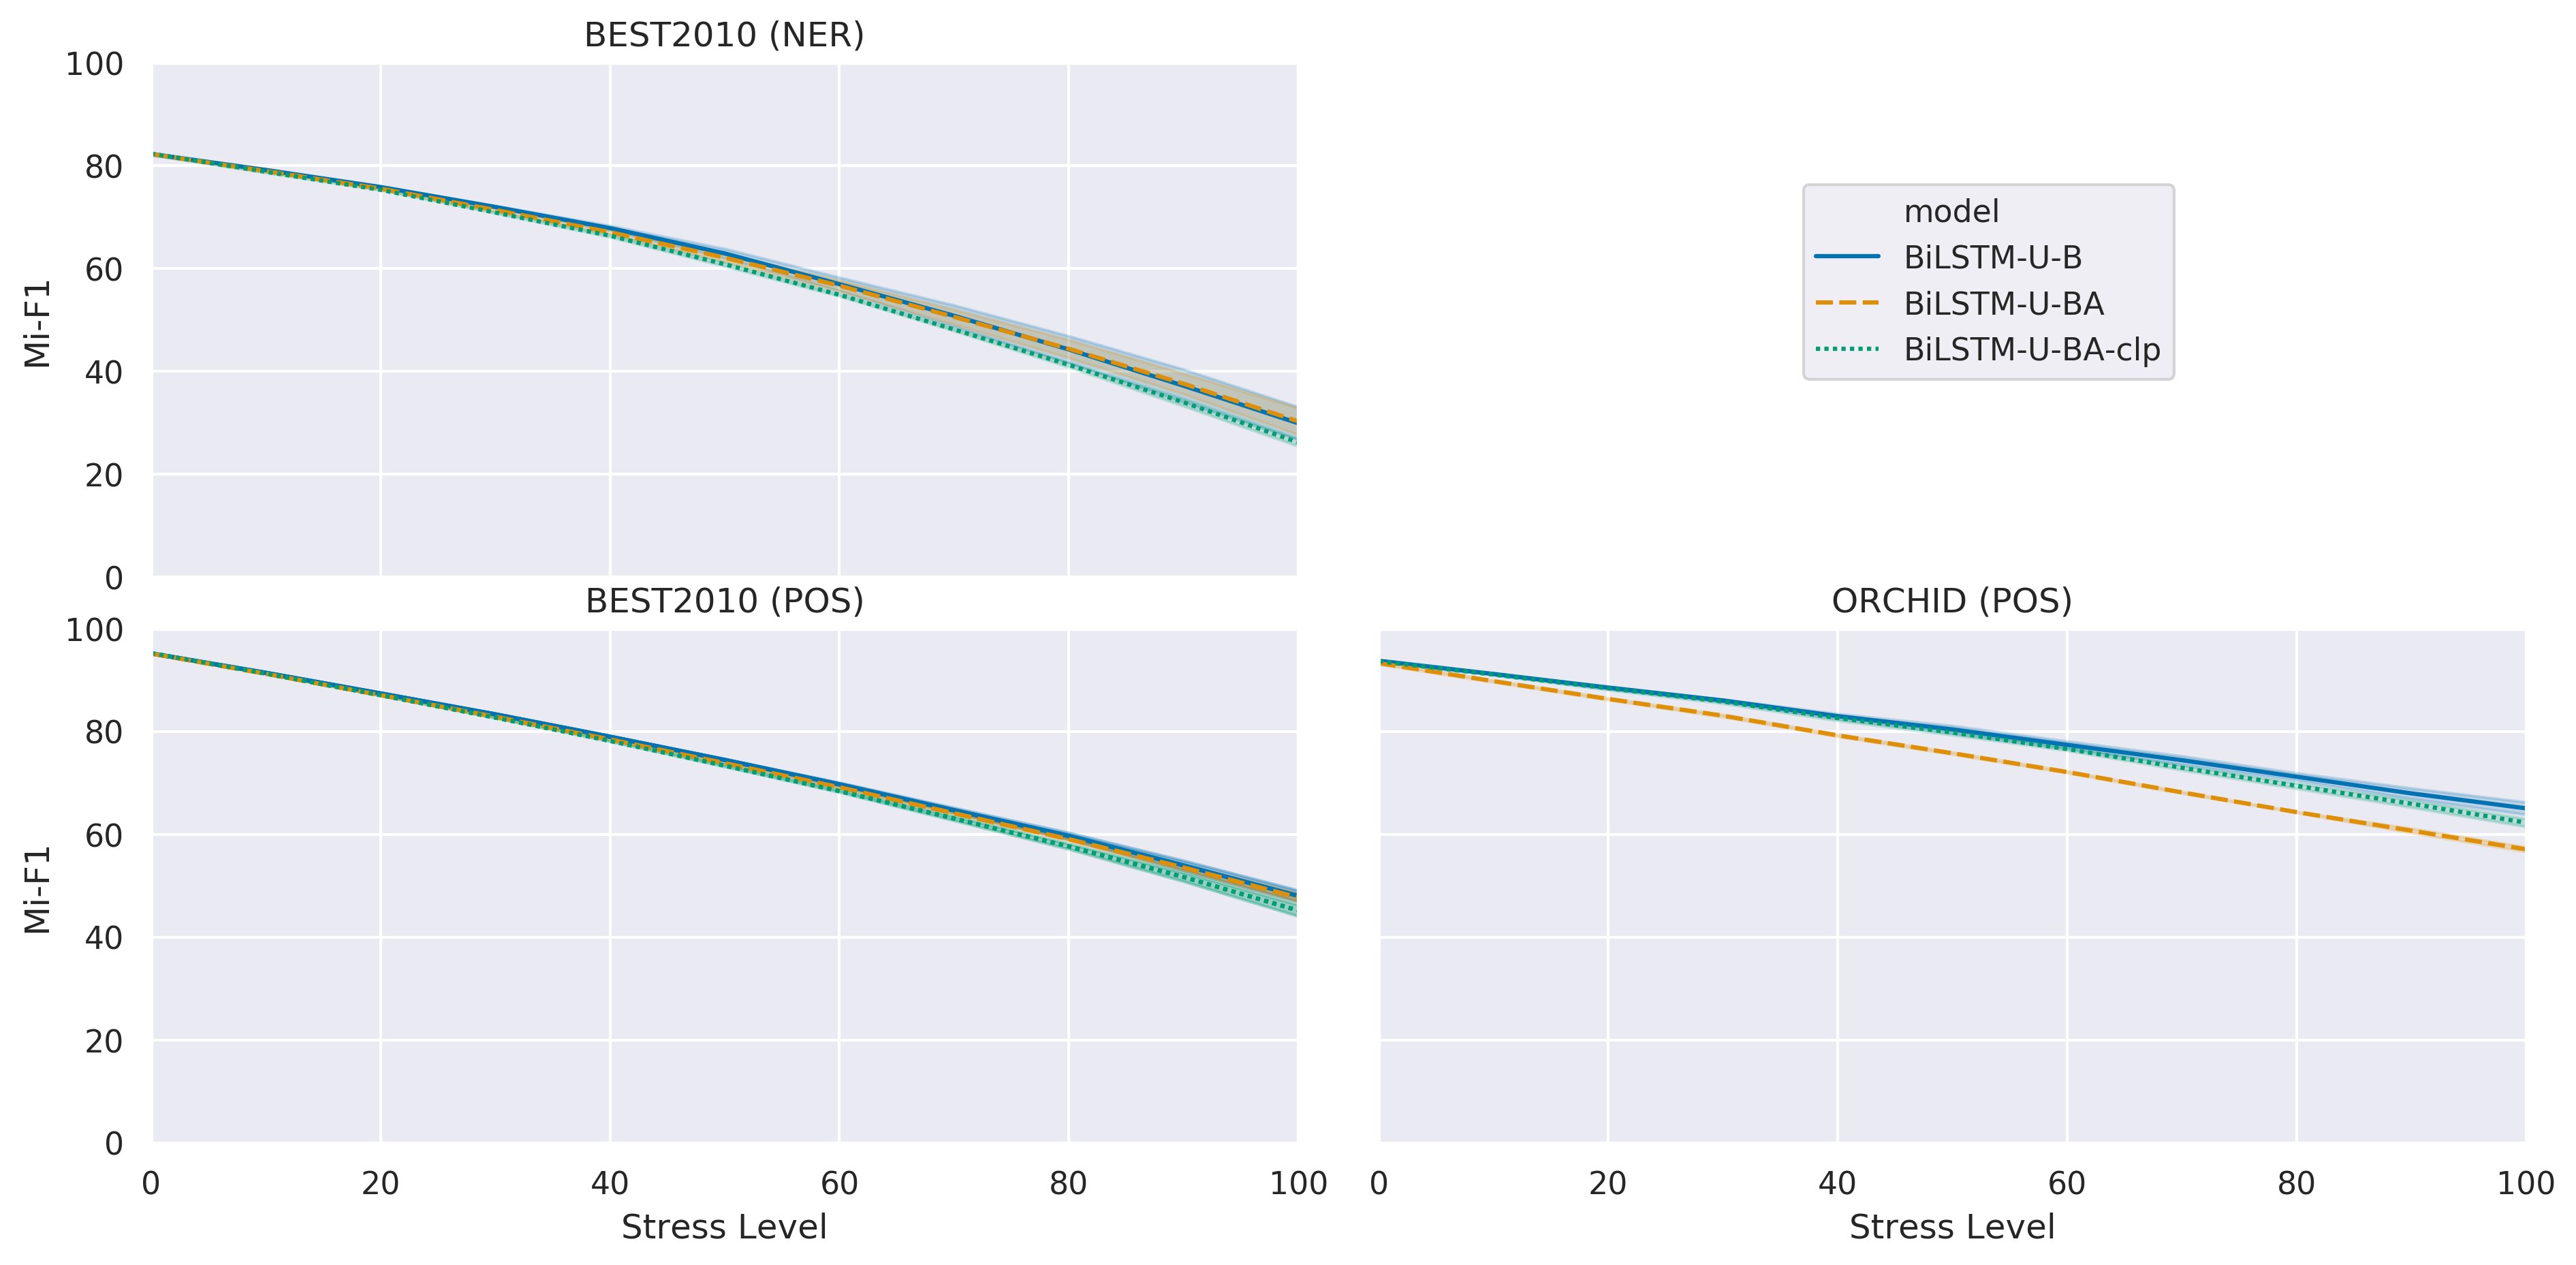

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,7),sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.07})
(ax1, ax2), (ax3, ax4) = axs
# fig.suptitle('Axes values are scaled individually by default')
ax2.set_facecolor('white')

mul_plt = sns.lineplot(x="stress level", y="Mi-F1 NER",ax=ax1,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U-B") | (best_df.model=="BiLSTM-U-BA")| (best_df.model=="BiLSTM-U-BA-clp")   ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1",ax=ax4,legend=False, hue='model', style="model",ci="sd" ,data=orchid_df[(orchid_df.model=="BiLSTM-UB")  | (orchid_df.model=="BiLSTM-UBA")| (orchid_df.model=="BiLSTM-UBA-clp")  ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U-B") |(best_df.model=="BiLSTM-U-BA") |  (best_df.model=="BiLSTM-U-BA-clp")  ])

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7, 0.7))
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U-B") |(best_df.model=="BiLSTM-U-BA")  | (best_df.model=="BiLSTM-U-BA-clp") ])
mul_plt.legend_.remove()
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
sns.set_palette("colorblind")
mul_plt.set(ylim=(0, 100))
mul_plt.set(xlim=(0, 100))
ax1.set_title("BEST2010 (NER)")
ax3.set_title("BEST2010 (POS)")
ax4.set_title("ORCHID (POS)")
fig.set_dpi(300)
fig.savefig("AttnVSBackoff-Results.pdf", bbox_inches='tight')

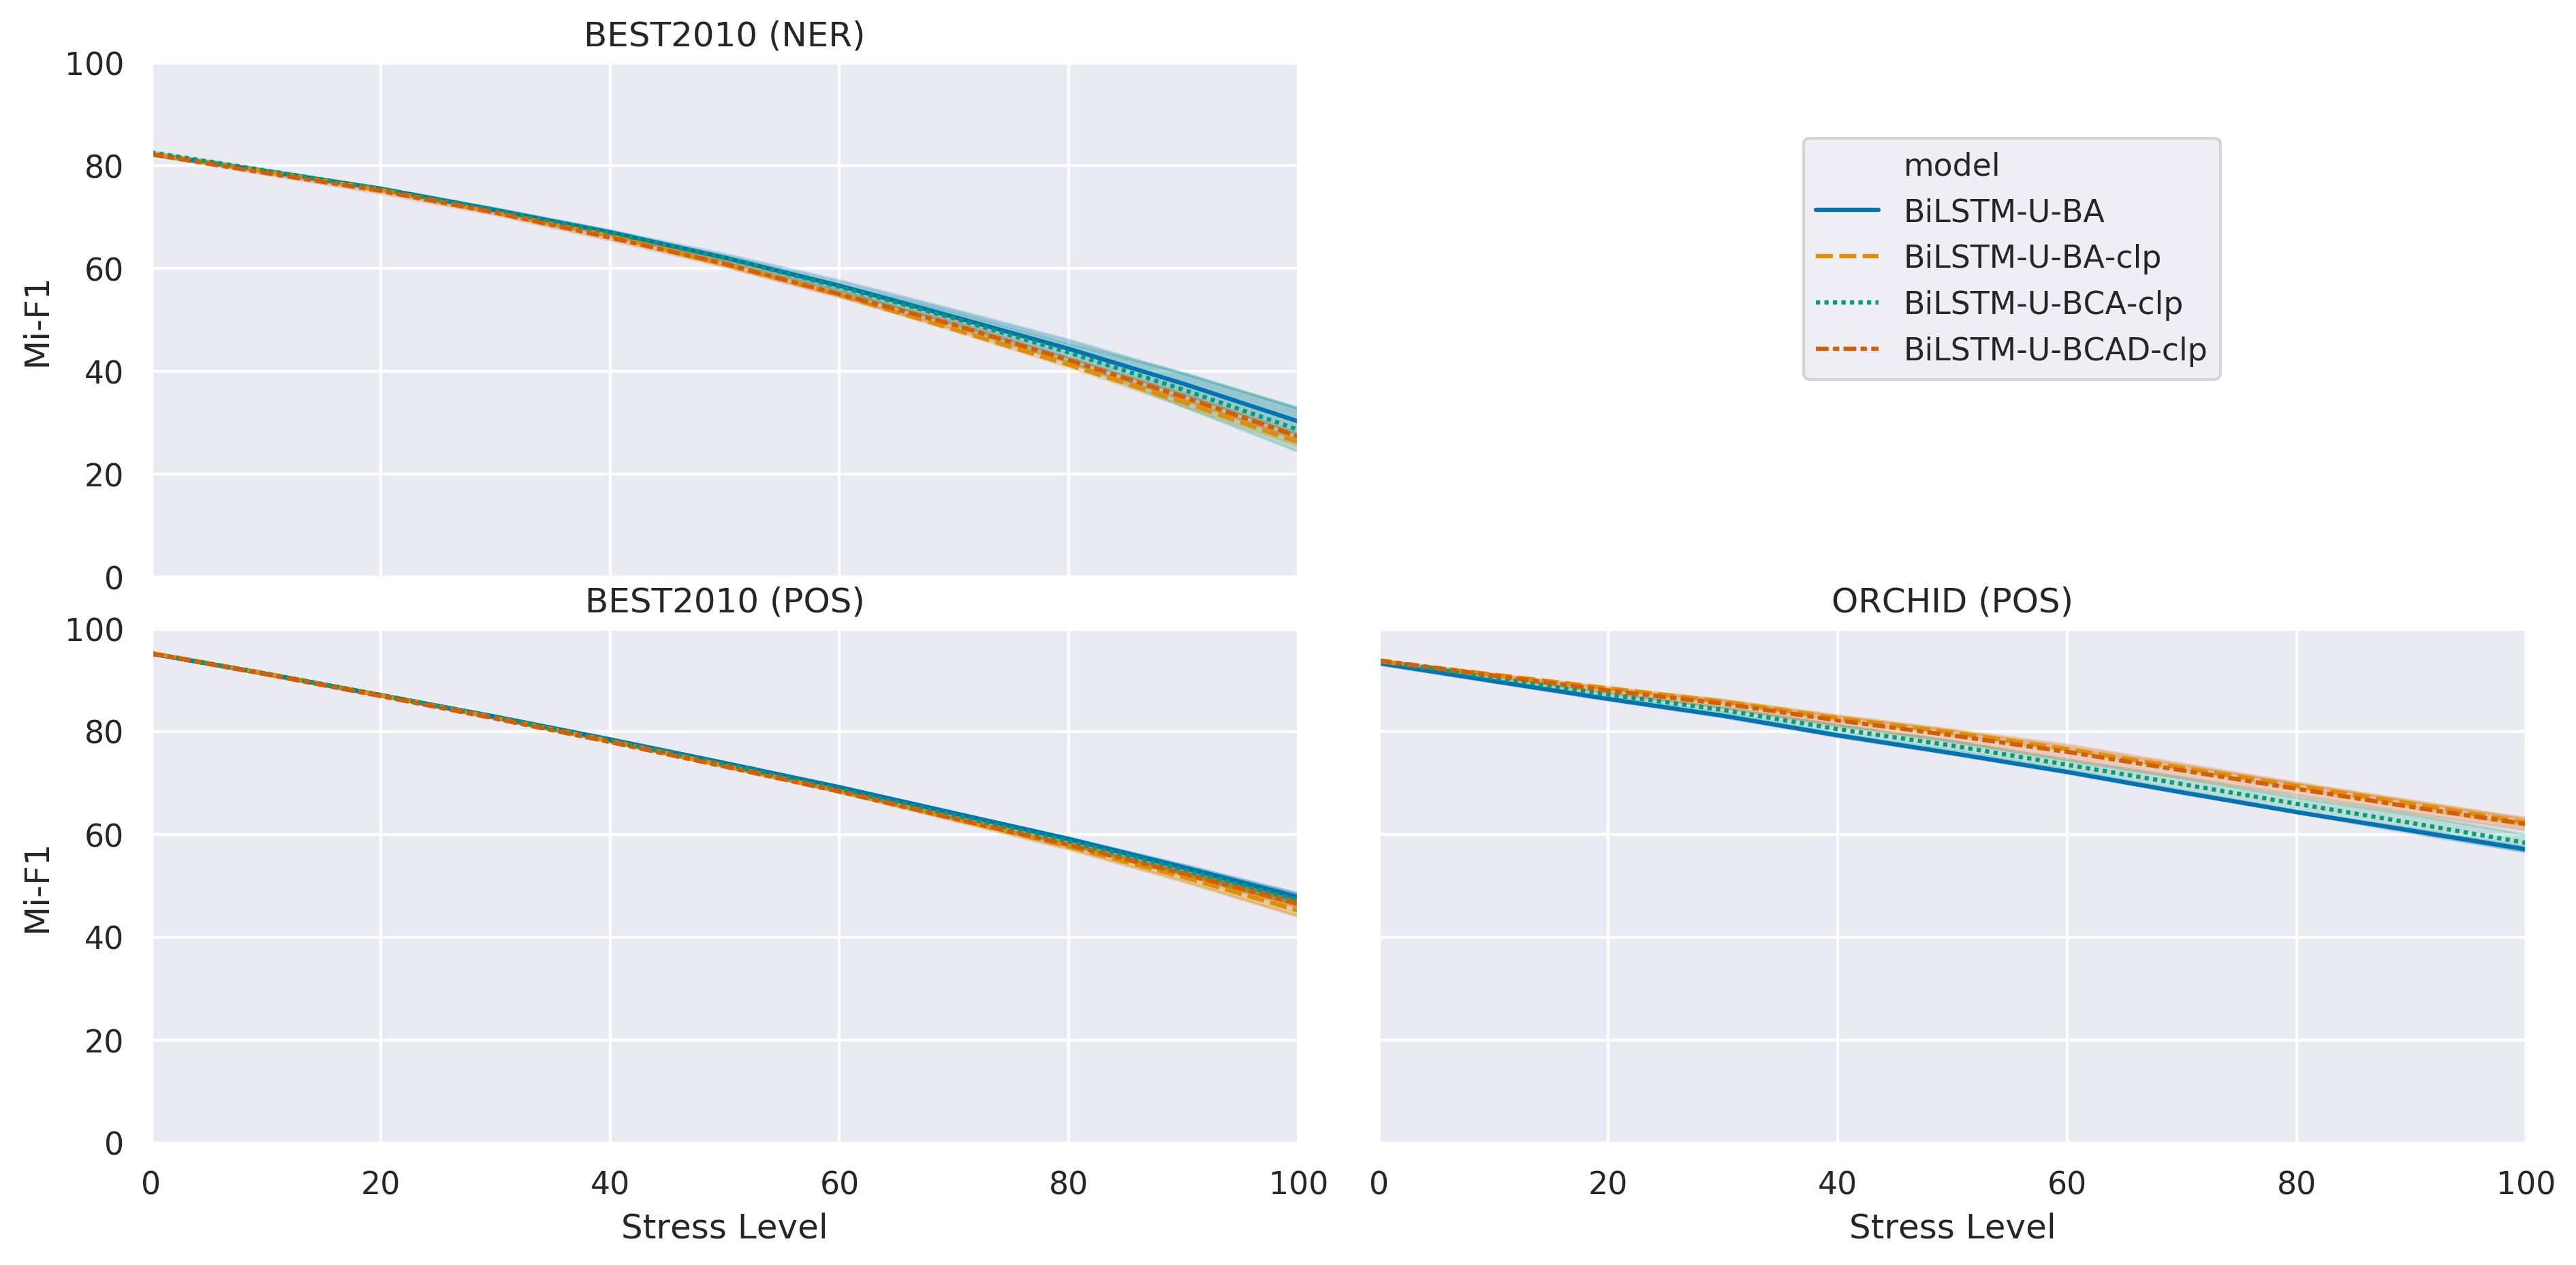

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,7),sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.07})
(ax1, ax2), (ax3, ax4) = axs
# fig.suptitle('Axes values are scaled individually by default')
ax2.set_facecolor('white')

mul_plt = sns.lineplot(x="stress level", y="Mi-F1 NER",ax=ax1,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM-U-BA")|\
                                                                                                              (best_df.model=="BiLSTM-U-BA-clp")| (best_df.model=="BiLSTM-U-BCA-clp")|\
                                                                                                              (best_df.model=="BiLSTM-U-BCAD-clp") ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1",ax=ax4,legend=False, hue='model', style="model",ci="sd" ,data=orchid_df[ (orchid_df.model=="BiLSTM-UBA")|\
                                                                                                              (orchid_df.model=="BiLSTM-UBA-clp")| (orchid_df.model=="BiLSTM-U-BCA-clp")|\
                                                                                                              (orchid_df.model=="BiLSTM-U-BCAD-clp") ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3, hue='model', style="model",ci="sd" ,data=best_df[ (best_df.model=="BiLSTM-U-BA")|\
                                                                                                              (best_df.model=="BiLSTM-U-BA-clp")| (best_df.model=="BiLSTM-U-BCA-clp")|\
                                                                                                              (best_df.model=="BiLSTM-U-BCAD-clp") ])

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7, 0.7))
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3,legend=False, hue='model', style="model",ci="sd" ,data=best_df[ (best_df.model=="BiLSTM-U-BA") |\
                                                                                                              (best_df.model=="BiLSTM-U-BA-clp")| (best_df.model=="BiLSTM-U-BCA-clp")|\
                                                                                                              (best_df.model=="BiLSTM-U-BCAD-clp") |(best_df.model=="BiLSTM-U-BCAD-clp")  ])
mul_plt.legend_.remove()
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
sns.set_palette("colorblind")
mul_plt.set(ylim=(0, 100))
mul_plt.set(xlim=(0, 100))
ax1.set_title("BEST2010 (NER)")
ax3.set_title("BEST2010 (POS)")
ax4.set_title("ORCHID (POS)")
fig.set_dpi(300)
fig.savefig("AttnVariations-Results.pdf", bbox_inches='tight')

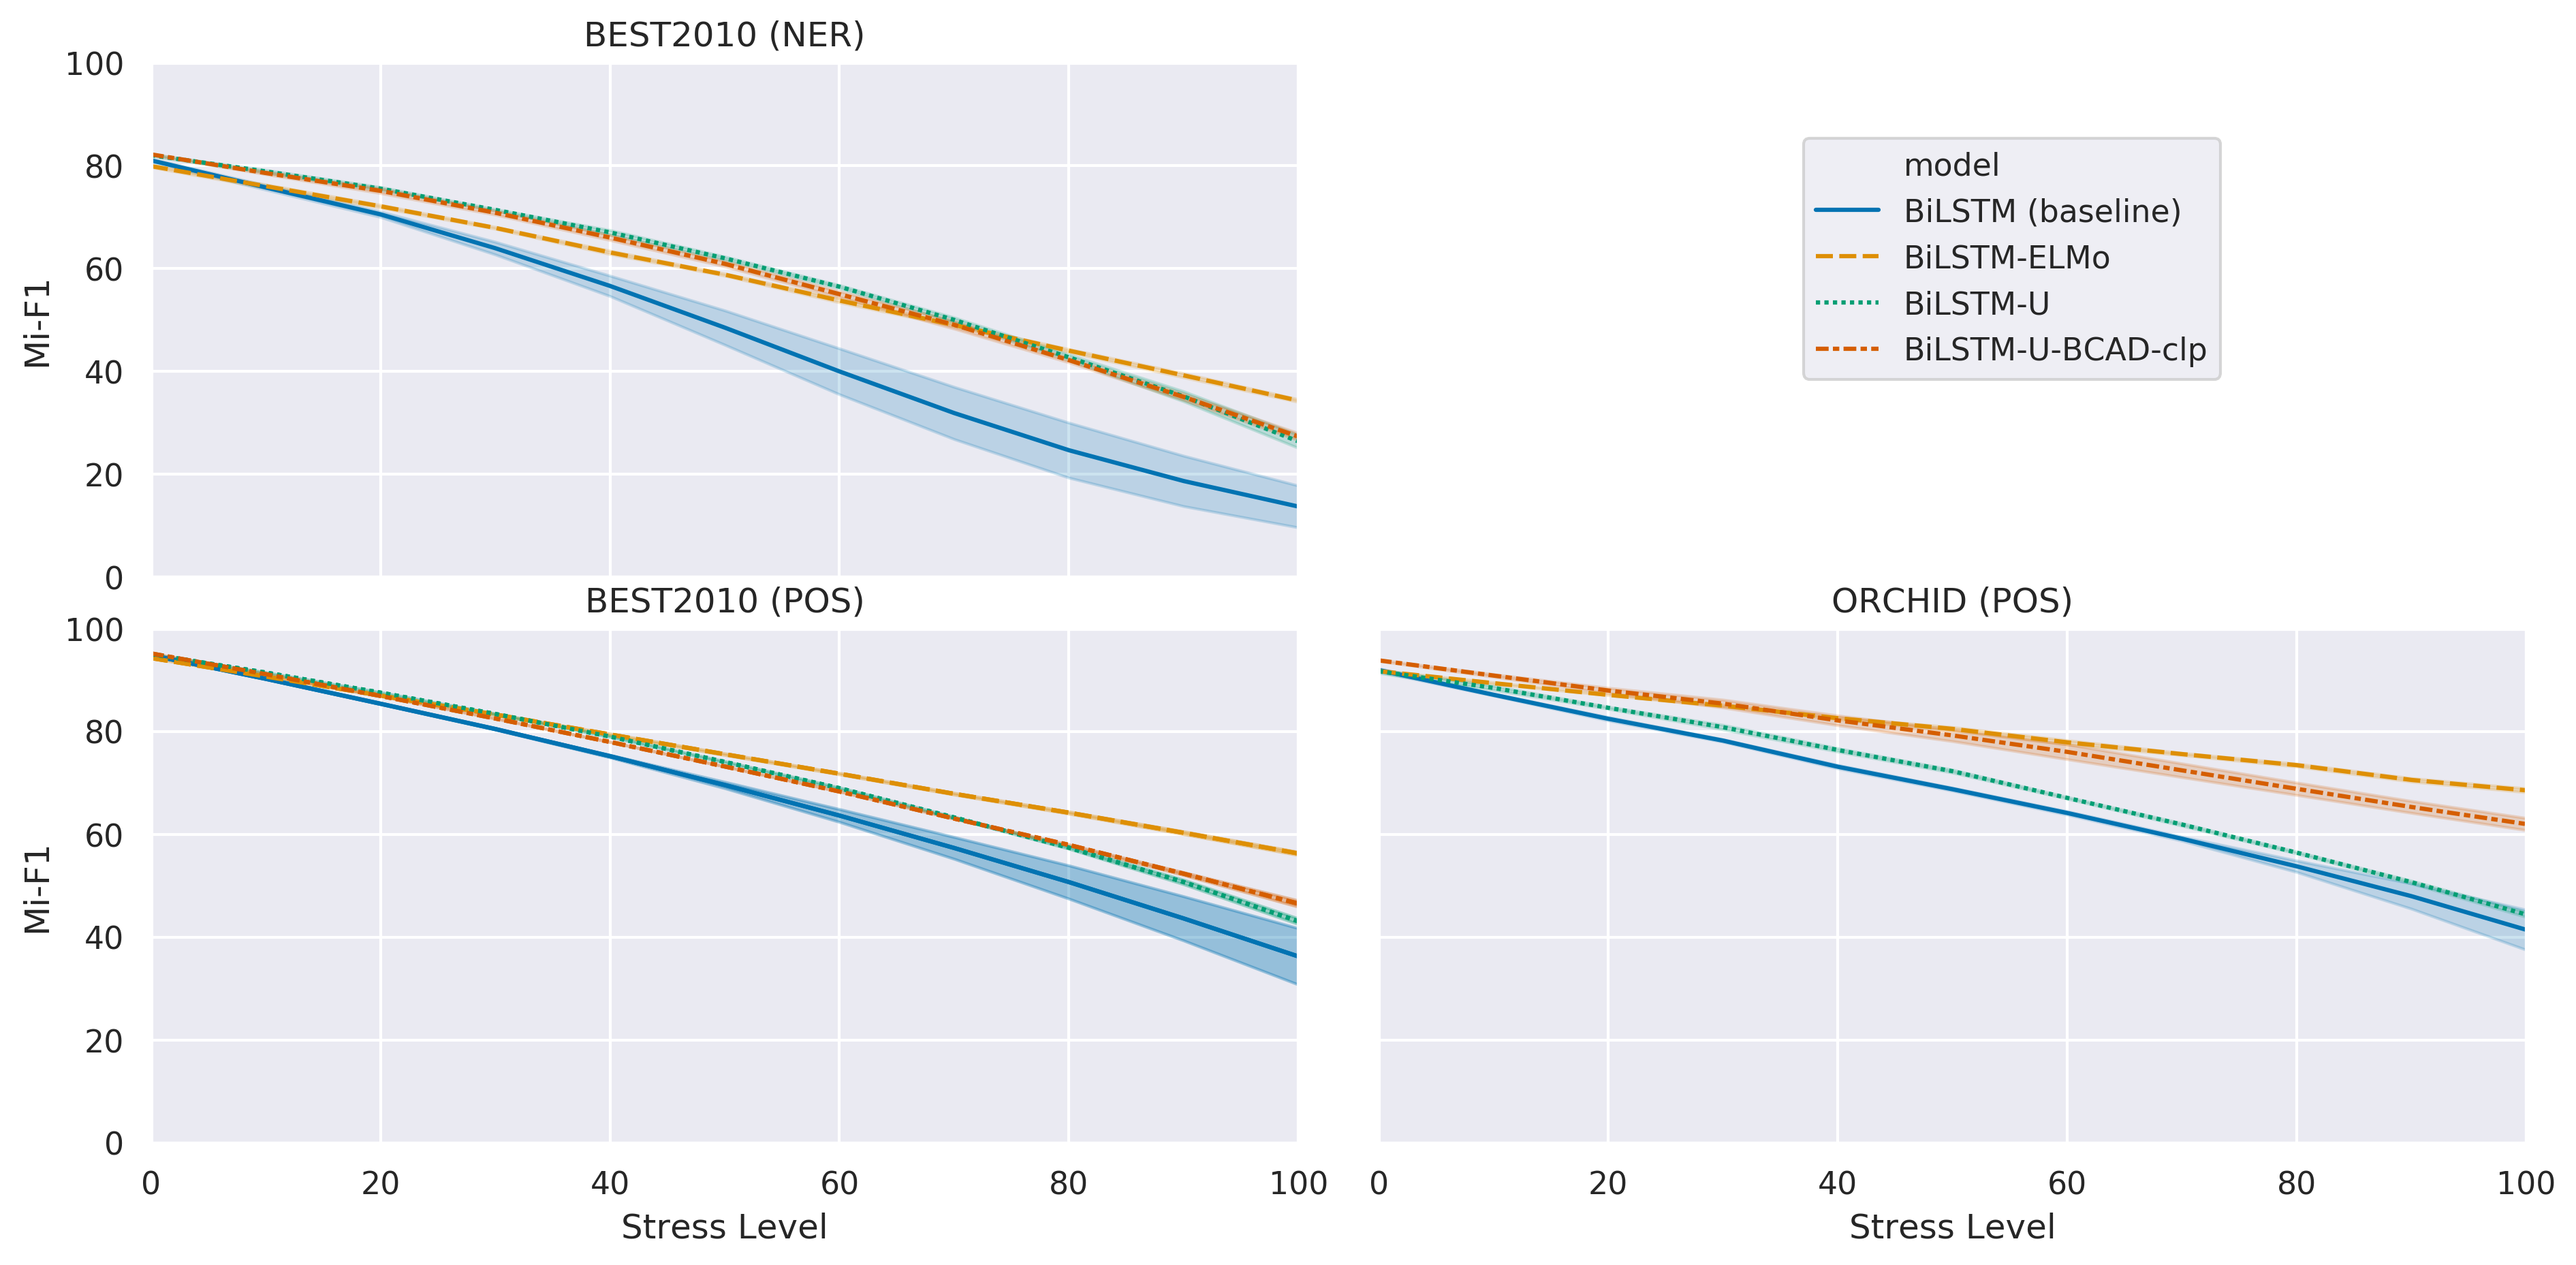

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,7),sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.1, 'wspace': 0.07})
(ax1, ax2), (ax3, ax4) = axs
# fig.suptitle('Axes values are scaled individually by default')
ax2.set_facecolor('white')

mul_plt = sns.lineplot(x="stress level", y="Mi-F1 NER",ax=ax1,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM (baseline)") |\
                                                                                                              (best_df.model=="BiLSTM-U") | (best_df.model=="BiLSTM-U-BCAD-clp")\
                                                                                                              |(best_df.model=="BiLSTM-ELMo") ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1",ax=ax4,legend=False, hue='model', style="model",ci="sd" ,data=orchid_df[(orchid_df.model=="BiLSTM (baseline)") | \
                                                                                                            (orchid_df.model=="BiLSTM-U") |\
                                                                                                            (best_df.model=="BiLSTM-U-BCAD-clp") |(best_df.model=="BiLSTM-ELMo") ])
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM (baseline)") | \
                                                                                                 (best_df.model=="BiLSTM-U")|(best_df.model=="BiLSTM-U-BCAD-clp")\
                                                                                                 |(best_df.model=="BiLSTM-ELMo")])

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.7, 0.7))
mul_plt = sns.lineplot(x="stress level", y="Mi-F1 POS",ax=ax3,legend=False, hue='model', style="model",ci="sd" ,data=best_df[(best_df.model=="BiLSTM (baseline)") | \
                                                                                                              (best_df.model=="BiLSTM-U") |(best_df.model=="BiLSTM-U-BCAD-clp")\
                                                                                                              |(best_df.model=="BiLSTM-ELMo")])
mul_plt.legend_.remove()
mul_plt.set(xlabel='Stress Level', ylabel='Mi-F1')
sns.set_palette("colorblind")
mul_plt.set(ylim=(0, 100))
mul_plt.set(xlim=(0, 100))
ax1.set_title("BEST2010 (NER)")
ax3.set_title("BEST2010 (POS)")
ax4.set_title("ORCHID (POS)")
fig.set_dpi(300)
fig.savefig("ELMo-Results.pdf", bbox_inches='tight')